In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
import random
import pymc3 as pm
import theano

%matplotlib inline

In [2]:
N = 2

freq_min = 100.
freq_max = 110.
freq_range = np.linspace(freq_min,freq_max,num=60)

angle_min = -pi/2
angle_max = pi/2
sig_min = 5.
sig_max = 100.

sigma_range = np.linspace(sig_min,sig_max, num=1000)
theta_range = np.linspace(angle_min,angle_max,num=1000)

beta_i = -2.7
b = 14.6
nu_0 = 100.
a_i = 1.
e = np.exp(1)

sigma_theta = 0.1
sigma_sig = 1

def vis_sps(theta_i,sig_1,sig_2,nu=100.) :
    lm = 3e8 / (nu * 1e6)
    T = a_i * (nu/nu_0)**beta_i
    A_p = np.exp(-0.5*((theta_i/(sig_1*np.pi/180.))**2 + (theta_i/(sig_2*np.pi/180.))**2))
    f = np.exp(-1j*2*pi*b*theta_i*lm)
    return  T*A_p*f

def visibility(theta,sig_1,sig_2,nu=100.) :
    real_res = 0
    imag_res = 0
    for  i in range(N):
        theta_i = theta[i]
        real_res += np.real(vis_sps(theta_i,sig_1,sig_2,nu))
        imag_res += np.imag(vis_sps(theta_i,sig_1,sig_2,nu))
    return [real_res,imag_res]

In [3]:
random.seed(10)
sig_1_data = 10. 
sig_2_data = 10.
theta_data = [0.1,0.1]#np.random.uniform(angle_min,angle_max,N)

v_data = visibility(theta_data,sig_1_data,sig_2_data,freq_range)

print('sig_1_data = ' + str(sig_1_data))
print('sig_2_data = ' + str(sig_2_data))
print('theta_1_data = ' + str(theta_data[0]))
print('theta_2_data = ' + str(theta_data[1]))

sig_1_data = 10.0
sig_2_data = 10.0
theta_1_data = 0.1
theta_2_data = 0.1


In [4]:
def logL(theta_model, sig_1_model, sig_2_model) :
    v_model = visibility(theta_model,sig_1_model,sig_2_model,freq_range)
    return -0.5*(np.sum((v_model[0]-v_data[0])**2) + np.sum((v_model[1]-v_data[1])**2))

### We make only one parameter to vary

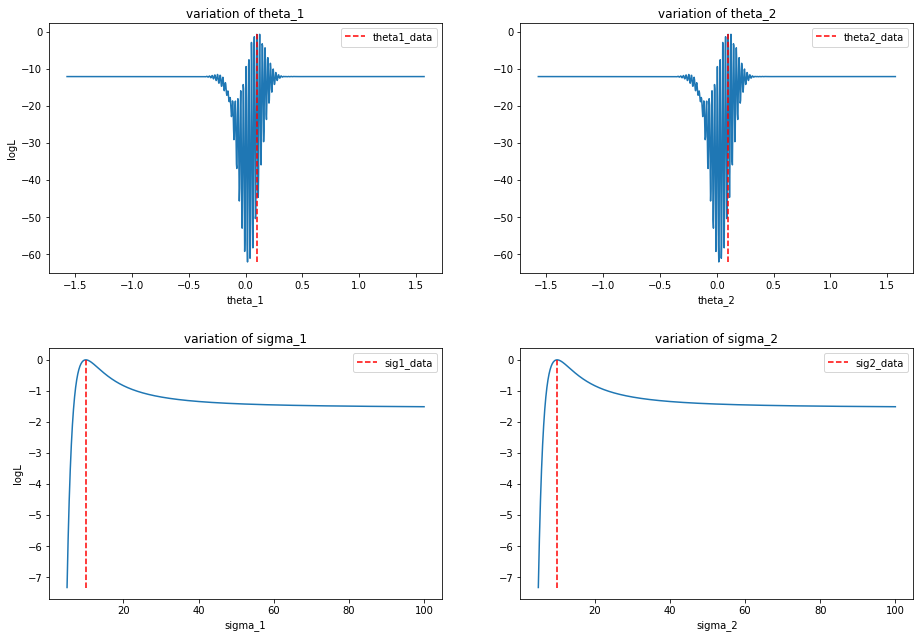

In [5]:
theta2D_1 = [[theta_r,theta_data[1]] for theta_r in theta_range]
theta2D_1_rev = [[theta_r,theta_data[1]] for theta_r in np.linspace(angle_max,angle_min,num=200)]
theta2D_2 = [[theta_data[0],theta_r] for theta_r in theta_range]

logL_theta1 = np.array([logL(theta2D_r,sig_1_data,sig_2_data) for theta2D_r in theta2D_1])
logL_theta2 = np.array([logL(theta2D_r,sig_1_data,sig_2_data) for theta2D_r in theta2D_2])
logL_sig1 = np.array([logL(theta_data,sig_1,sig_2_data) for sig_1 in sigma_range])
logL_sig2 = np.array([logL(theta_data,sig_1_data,sig_2) for sig_2 in sigma_range])

fig, ax = plt.subplots(2, 2)
fig.subplots_adjust(left=1, right=3,top=3,bottom=1, hspace=0.3, wspace=0.2)

ax[0][0].plot(theta_range, logL_theta1)
ax[0][0].plot([theta_data[0],theta_data[0]],[min(logL_theta1),max(logL_theta1)],'r--',label='theta1_data')
ax[0][0].set_xlabel('theta_1')
ax[0][0].set_ylabel('logL')
ax[0][0].set_title('variation of theta_1')
ax[0][0].legend()

ax[0][1].plot(theta_range, logL_theta2)
ax[0][1].plot([theta_data[1],theta_data[1]],[min(logL_theta2),max(logL_theta2)],'r--',label='theta2_data')
ax[0][1].set_xlabel('theta_2')
ax[0][1].set_title('variation of theta_2')
ax[0][1].legend()

ax[1][0].plot(sigma_range, logL_sig1)
ax[1][0].plot([sig_1_data,sig_1_data],[min(logL_sig1),max(logL_sig1)],'r--',label='sig1_data')
ax[1][0].set_xlabel('sigma_1')
ax[1][0].set_ylabel('logL')
ax[1][0].set_title('variation of sigma_1')
ax[1][0].legend()

ax[1][1].plot(sigma_range, logL_sig2)
ax[1][1].plot([sig_2_data,sig_2_data],[min(logL_sig2),max(logL_sig2)],'r--',label='sig2_data')
ax[1][1].set_xlabel('sigma_2')
ax[1][1].set_title('variation of sigma_2')
ax[1][1].legend()

## We add a Prior and then define the log posterior

In fact, we know where each source is likely to be within a certain range of theta. We add a prior to every parameters. It is modelised by a gaussian centered in the real value `***_i_data` with a variance of `sigma_***`

In [6]:
def logP_theta(theta_i,theta_i_prior) :
    return - (theta_i - theta_i_prior)**2  / (2*sigma_theta**2)

def logP_sigma(sig,sig_prior) :
    return - (sig - sig_prior)**2  / (2*sigma_sig**2)

def P_logL(theta_model, sig_1_model, sig_2_model) :
    v_model = visibility(theta_model,sig_1_model,sig_2_model,freq_range)
    D = len(theta_model)
    p = logP_sigma(sig_1_model,sig_1_data) + logP_sigma(sig_2_model,sig_2_data)
    for i in range(D):
        p += logP_theta(theta_model[i],theta_data[i])
    return p + logL(theta_model, sig_1_model, sig_2_model)

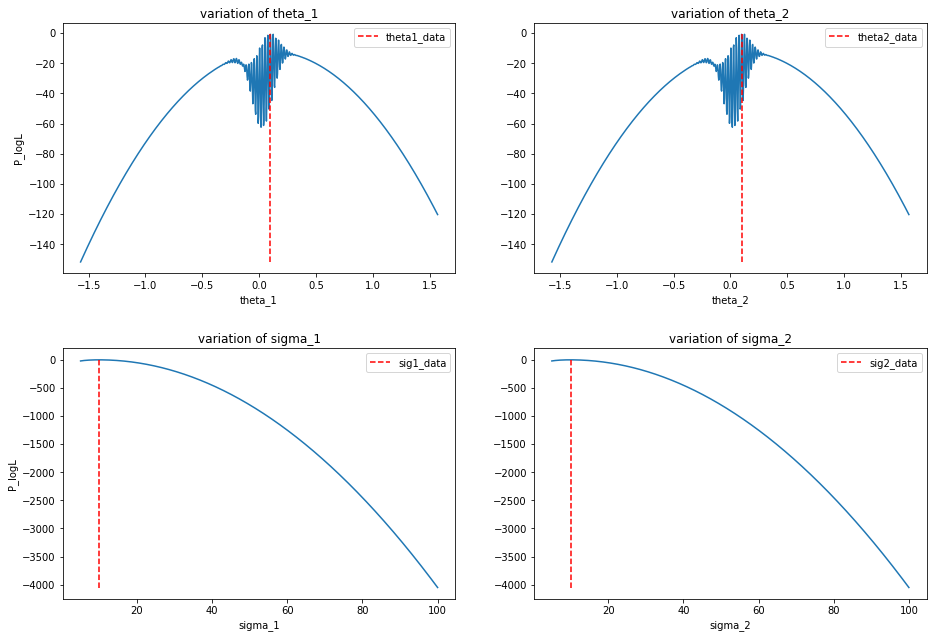

In [7]:
P_logL_theta1 = [P_logL(theta2D_r,sig_1_data,sig_2_data) for theta2D_r in theta2D_1]
P_logL_theta2 = [P_logL(theta2D_r,sig_1_data,sig_2_data) for theta2D_r in theta2D_2]
P_logL_sig1 = np.array([P_logL(theta_data,sig_1,sig_2_data) for sig_1 in sigma_range])
P_logL_sig2 = np.array([P_logL(theta_data,sig_1_data,sig_2) for sig_2 in sigma_range])

fig, ax = plt.subplots(2, 2)
fig.subplots_adjust(left=1, right=3,top=3,bottom=1, hspace=0.3, wspace=0.2)

ax[0][0].plot(theta_range, P_logL_theta1)
ax[0][0].plot([theta_data[0],theta_data[0]],[min(P_logL_theta1),max(P_logL_theta1)],'r--',label='theta1_data')
ax[0][0].set_xlabel('theta_1')
ax[0][0].set_ylabel('P_logL')
ax[0][0].set_title('variation of theta_1')
ax[0][0].legend()

ax[0][1].plot(theta_range, P_logL_theta2)
ax[0][1].plot([theta_data[1],theta_data[1]],[min(P_logL_theta2),max(P_logL_theta2)],'r--',label='theta2_data')
ax[0][1].set_xlabel('theta_2')
ax[0][1].set_title('variation of theta_2')
ax[0][1].legend()

ax[1][0].plot(sigma_range, P_logL_sig1)
ax[1][0].plot([sig_1_data,sig_1_data],[min(P_logL_sig1),max(P_logL_sig1)],'r--',label='sig1_data')
ax[1][0].set_xlabel('sigma_1')
ax[1][0].set_ylabel('P_logL')
ax[1][0].set_title('variation of sigma_1')
ax[1][0].legend()

ax[1][1].plot(sigma_range, P_logL_sig2)
ax[1][1].plot([sig_2_data,sig_2_data],[min(P_logL_sig2),max(P_logL_sig2)],'r--',label='sig2_data')
ax[1][1].set_xlabel('sigma_2')
ax[1][1].set_title('variation of sigma_2')
ax[1][1].legend()

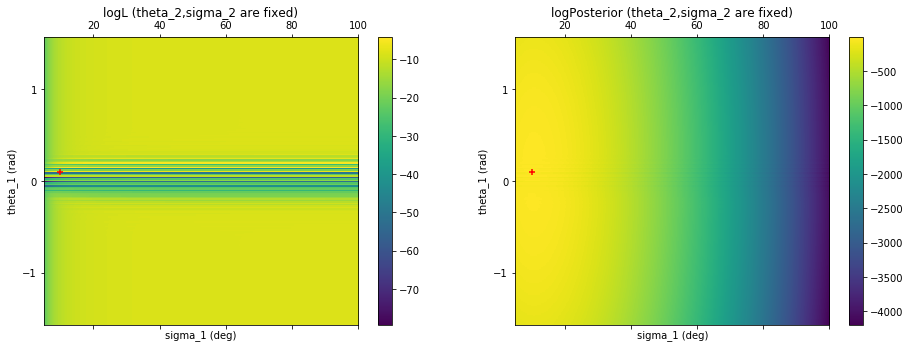

In [8]:
logL_theta1_sig1 = np.array([[logL(theta2D_r,sig1,sig_2_data) for sig1 in sigma_range] for theta2D_r in theta2D_1_rev])
P_logL_theta1_sig1 = np.array([[P_logL(theta2D_r,sig1,sig_2_data) for sig1 in sigma_range] for theta2D_r in theta2D_1_rev])

fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=1, right=3,top=3,bottom=2, hspace=0.3, wspace=0.2)

im1 = ax[0].matshow(logL_theta1_sig1,extent=[sig_min,sig_max,angle_min,angle_max],cmap='viridis',aspect='auto')
ax[0].set_xlabel("sigma_1 (deg)")
ax[0].set_ylabel("theta_1 (rad)")
ax[0].set_title("logL (theta_2,sigma_2 are fixed)")
fig.colorbar(im1,ax = ax[0])
ax[0].scatter(sig_1_data, theta_data[0],marker = '+', color = 'r')

im2 = ax[1].matshow(P_logL_theta1_sig1,extent=[sig_min,sig_max,angle_min,angle_max],cmap='viridis',aspect='auto')
ax[1].set_xlabel("sigma_1 (deg)")
ax[1].set_ylabel("theta_1 (rad)")
ax[1].set_title("logPosterior (theta_2,sigma_2 are fixed)")
fig.colorbar(im2)
ax[1].scatter(sig_1_data, theta_data[0],marker = '+', color = 'r')

# FIND THE PARAMETERS WITH A SAMPLER


In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm 

N = 2 #Number of parameters 

def my_model(param,nu) :
    theta = param[0:N]
    sig_1 = param[-2]
    sig_2 = param[-1]
    return visibility(theta,sig_1,sig_2,nu)

def my_loglike(param,nu,data,sigma) :
    model = my_model(param,nu)
    return -0.5/(sigma**2) * (np.sum(model[0] - data[0])**2 + np.sum(model[1] - data[1])**2)


N_datapts = 100 #number of data points
sigma = 0.1  # standard deviation of noise
nu = np.linspace(freq_min, 200.,num=N_datapts)

true_params = [0.1 + 0.001*np.random.randn() for i in range(N)]   + [10.,10.]


true_model = my_model(true_params,nu)

data = true_model + sigma*np.random.randn(N_datapts) #true_model + some noise 

ndraws = 5000  # number of draws from the distribution
nburn = 1000   # number of "burn-in points" (which we'll discard)

In [10]:
import theano.tensor as tt

# define a theano Op for our likelihood function
class LogLike(tt.Op):

    """
    Specify what type of object will be passed and returned to the Op when it is
    called. In our case we will be passing it a vector of values (the parameters
    that define our model) and returning a single "scalar" value (the
    log-likelihood)
    """
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, nu, sigma):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that our function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.nu = nu
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        param, = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(param, self.nu, self.data, self.sigma)

        outputs[0][0] = np.array(logl) # output the log-likelihood

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sig_2]
>Slice: [sig_1]
>Slice: [theta_2]
>Slice: [theta_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [01:01<00:00, 360.32draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f04b66aea10>,
      dtype=object)

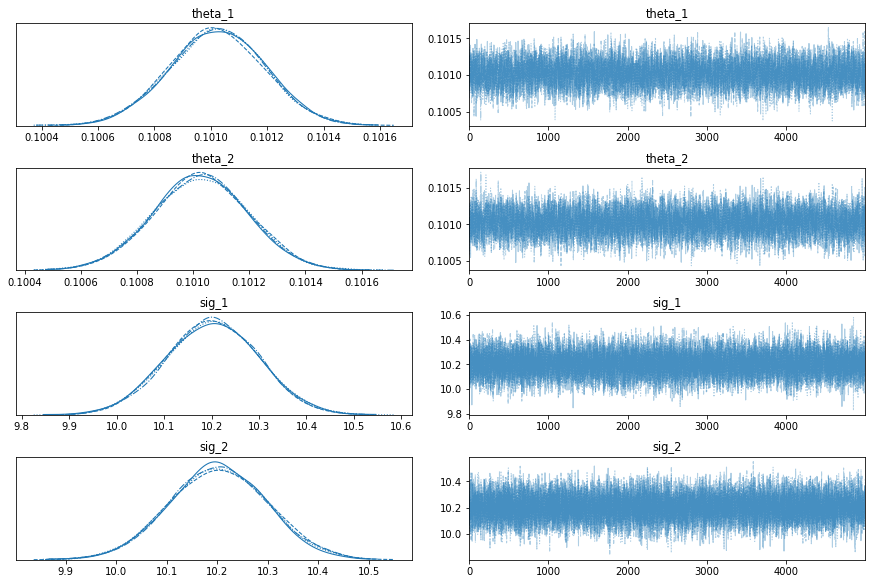

In [11]:
# create our Op
logl = LogLike(my_loglike, data, nu, sigma)

# use PyMC3 to sampler from log-likelihood
with pm.Model():
    param = []
    # Gaussian priors on parameters
    for i in range(N) :
        theta_i = pm.Normal('theta_'+str(i+1),mu=true_params[i],sigma=1)
        param.append(theta_i)
        
    sig_1 = pm.Normal('sig_1',mu=true_params[-2],sigma=0.1)
    param.append(sig_1)
    sig_2 = pm.Normal('sig_2',mu=true_params[-1],sigma=0.1)
    param.append(sig_2)
    
    
    # convert a and b to a tensor vector
    param_tensor = tt.as_tensor_variable(param)

    #use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': param_tensor})

    trace = pm.sample(ndraws) #, tune=nburn, discard_tuned_samples=True

# plot the traces
pm.traceplot(trace)

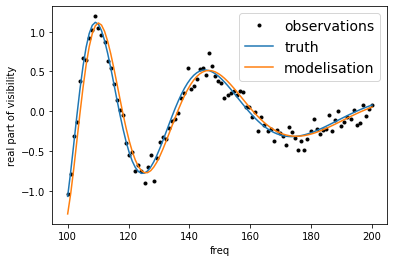

In [12]:
observed_params = [np.mean(trace['theta_'+str(i+1)]) for i in range(N)]+ [np.mean(trace['sig_1']), np.mean(trace['sig_2'])]
modelisation = my_model(observed_params,nu) 

plt.plot(nu,data[0], ".k", label="observations")
plt.plot(nu, true_model[0], label="truth")
plt.plot(nu,modelisation[0],label="modelisation")
plt.xlabel("freq")
plt.ylabel("real part of visibility")
plt.legend(fontsize=14);

In [13]:
print('true parameters : '+ str(true_params))
print('observed parameters : '+ str(observed_params))

true parameters : [0.09958154767051824, 0.10067396079537974, 10.0, 10.0]
observed parameters : [0.10102204567431637, 0.10102760647025759, 10.20255133060696, 10.202664297749175]


# GRADIENT BASED SAMPLER

In [14]:
import warnings

def gradients(vals, func, releps=1e-3, abseps=None, mineps=1e-9, reltol=1e-3,
              epsscale=0.5):
    """
    Calculate the partial derivatives of a function at a set of values. The
    derivatives are calculated using the central difference, using an iterative
    method to check that the values converge as step size decreases.

    Parameters
    ----------
    vals: array_like
        A set of values, that are passed to a function, at which to calculate
        the gradient of that function
    func:
        A function that takes in an array of values.
    releps: float, array_like, 1e-3
        The initial relative step size for calculating the derivative.
    abseps: float, array_like, None
        The initial absolute step size for calculating the derivative.
        This overrides `releps` if set.
        `releps` is set then that is used.
    mineps: float, 1e-9
        The minimum relative step size at which to stop iterations if no
        convergence is achieved.
    epsscale: float, 0.5
        The factor by which releps if scaled in each iteration.

    Returns
    -------
    grads: array_like
        An array of gradients for each non-fixed value.
    """

    grads = np.zeros(len(vals))

    # maximum number of times the gradient can change sign
    flipflopmax = 10.

    # set steps
    if abseps is None:
        if isinstance(releps, float):
            eps = np.abs(vals)*releps
            eps[eps == 0.] = releps  # if any values are zero set eps to releps
            teps = releps*np.ones(len(vals))
        elif isinstance(releps, (list, np.ndarray)):
            if len(releps) != len(vals):
                raise ValueError("Problem with input relative step sizes")
            eps = np.multiply(np.abs(vals), releps)
            eps[eps == 0.] = np.array(releps)[eps == 0.]
            teps = releps
        else:
            raise RuntimeError("Relative step sizes are not a recognised type!")
    else:
        if isinstance(abseps, float):
            eps = abseps*np.ones(len(vals))
        elif isinstance(abseps, (list, np.ndarray)):
            if len(abseps) != len(vals):
                raise ValueError("Problem with input absolute step sizes")
            eps = np.array(abseps)
        else:
            raise RuntimeError("Absolute step sizes are not a recognised type!")
        teps = eps

    # for each value in vals calculate the gradient
    count = 0
    for i in range(len(vals)):
        # initial parameter diffs
        leps = eps[i]
        cureps = teps[i]

        flipflop = 0

        # get central finite difference
        fvals = np.copy(vals)
        bvals = np.copy(vals)

        # central difference
        fvals[i] += 0.5*leps  # change forwards distance to half eps
        bvals[i] -= 0.5*leps  # change backwards distance to half eps
        cdiff = (func(fvals)-func(bvals))/leps

        while 1:
            fvals[i] -= 0.5*leps  # remove old step
            bvals[i] += 0.5*leps

            # change the difference by a factor of two
            cureps *= epsscale
            if cureps < mineps or flipflop > flipflopmax:
                # if no convergence set flat derivative (TODO: check if there is a better thing to do instead)
                warnings.warn("Derivative calculation did not converge: setting flat derivative.")
                grads[count] = 0.
                break
            leps *= epsscale

            # central difference
            fvals[i] += 0.5*leps  # change forwards distance to half eps
            bvals[i] -= 0.5*leps  # change backwards distance to half eps
            cdiffnew = (func(fvals)-func(bvals))/leps

            if cdiffnew == cdiff:
                grads[count] = cdiff
                break

            # check whether previous diff and current diff are the same within reltol
            rat = (cdiff/cdiffnew)
            if np.isfinite(rat) and rat > 0.:
                # gradient has not changed sign
                if np.abs(1.-rat) < reltol:
                    grads[count] = cdiffnew
                    break
                else:
                    cdiff = cdiffnew
                    continue
            else:
                cdiff = cdiffnew
                flipflop += 1
                continue

        count += 1

    return grads

In [15]:
# define a theano Op for our likelihood function
class LogLikeWithGrad(tt.Op):

    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, nu, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.nu = nu
        self.sigma = sigma

        # initialise the gradient Op (below)
        self.logpgrad = LogLikeGrad(self.likelihood, self.data, self.nu, self.sigma)

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        param, = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(param, self.nu, self.data, self.sigma)

        outputs[0][0] = np.array(logl) # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        param, = inputs  # our parameters
        return [g[0]*self.logpgrad(param)]


class LogLikeGrad(tt.Op):

    """
    This Op will be called with a vector of values and also return a vector of
    values - the gradients in each dimension.
    """
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, loglike, data, nu, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.nu = nu
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        param, = inputs

        # define version of likelihood function to pass to derivative function
        def lnlike(values):
            return self.likelihood(values, self.nu, self.data, self.sigma)

        # calculate gradients
        grads = gradients(param, lnlike)

        outputs[0][0] = grads

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sig_2, sig_1, theta_2, theta_1]
Sampling 4 chains, 1 divergences: 100%|██████████| 22000/22000 [13:24<00:00, 27.35draws/s] 
The acceptance probability does not match the target. It is 0.9069903178890988, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f04b773ccd0>,
      dtype=object)

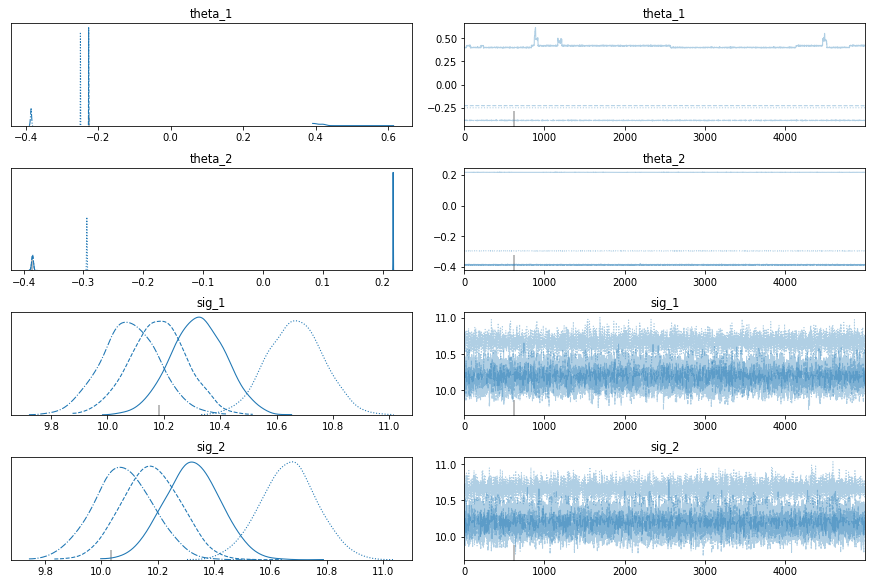

In [16]:
# create our Op
logl = LogLikeWithGrad(my_loglike, data, nu, sigma)

# use PyMC3 to sampler from log-likelihood
with pm.Model():
    
    param = []
    # Gaussian priors on parameters
    for i in range(N) :
        theta_i = pm.Normal('theta_'+str(i+1),mu=true_params[i],sigma=0.1)
        param.append(theta_i)
        
    sig_1 = pm.Normal('sig_1',mu=true_params[-2],sigma=0.1)
    param.append(sig_1)
    sig_2 = pm.Normal('sig_2',mu=true_params[-1],sigma=0.1)
    param.append(sig_2)
    
    
    # convert a and b to a tensor vector
    param_tensor = tt.as_tensor_variable(param)

    #use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': param_tensor})

    trace_NUTS = pm.sample(ndraws)

# plot the traces
pm.traceplot(trace_NUTS)

### The gradient-based sampler (NUTS or HMC) is much longer than the basic sampler. It comes from the fact that a manual gradient has to be computed at each step. There are 2 things that could optimise this algorithm. 
#### - Write the gradient as a non-generic function which is the true gradient of the logLikelihood
#### - Write the logLikelihood directly as a theano operator in order to use the theano gradient method which is optimised